# Análisis de Tópicos Latentes 
## Mediante Latent Dirichlet Allocation

Ruta de trabajo

1. Obtener acceso a la información
2. Organizar el corpus de trabajo
3. Pre procesamiento de datos
4. LDA
5. Resultados

### 1. Acceso a la información

In [1]:
from pydrive2.auth import GoogleAuth

In [2]:
gauth = GoogleAuth()
gauth.LocalWebserverAuth()

In [3]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive


directorio_credenciales = 'credentials_module.json'

# INICIAR SESION
def login():
    GoogleAuth.DEFAULT_SETTINGS['client_config_file'] = directorio_credenciales
    gauth = GoogleAuth()
    gauth.LoadCredentialsFile(directorio_credenciales)
    
    if gauth.credentials is None:
        gauth.LocalWebserverAuth(port_numbers=[8092])
    elif gauth.access_token_expired:
        gauth.Refresh()
    else:
        gauth.Authorize()
        
    gauth.SaveCredentialsFile(directorio_credenciales)
    credenciales = GoogleDrive(gauth)
    return credenciales

def crear_archivo_texto(nombre_archivo,contenido,id_folder):
    credenciales = login()
    archivo = credenciales.CreateFile({'title': nombre_archivo,\
                                       'parents': [{"kind": "drive#fileLink",\
                                                    "id": id_folder}]})
    archivo.SetContentString('Hey MoonCoders!')
    archivo.Upload()


# SUBIR UN ARCHIVO A DRIVE
def subir_archivo(ruta_archivo,id_folder):
    credenciales = login()
    archivo = credenciales.CreateFile({'parents': [{"kind": "drive#fileLink",\
                                                    "id": id_folder}]})
    archivo['title'] = ruta_archivo.split("/")[-1]
    archivo.SetContentFile(ruta_archivo)
    archivo.Upload()

# DESCARGAR UN ARCHIVO DE DRIVE POR ID
def bajar_archivo_por_id(id_drive,ruta_descarga):
    credenciales = login()
    archivo = credenciales.CreateFile({'id': id_drive}) 
    nombre_archivo = archivo['title']
    archivo.GetContentFile(ruta_descarga + nombre_archivo)

# BUSCAR ARCHIVOS
def busca(query):
    resultado = []
    credenciales = login()
    # Archivos con el nombre 'mooncode': title = 'mooncode'
    # Archivos que contengan 'mooncode' y 'mooncoders': title contains 'mooncode' and title contains 'mooncoders'
    # Archivos que NO contengan 'mooncode': not title contains 'mooncode'
    # Archivos que contengan 'mooncode' dentro del archivo: fullText contains 'mooncode'
    # Archivos en el basurero: trashed=true
    # Archivos que se llamen 'mooncode' y no esten en el basurero: title = 'mooncode' and trashed = false
    lista_archivos = credenciales.ListFile({'q': query}).GetList()
    for f in lista_archivos:
        # ID Drive
        print('ID Drive:',f['id'])
        # Link de visualizacion embebido
        print('Link de visualizacion embebido:',f['embedLink'])
        # Link de descarga
        print('Link de descarga:',f['downloadUrl'])
        # Nombre del archivo
        print('Nombre del archivo:',f['title'])
        # Tipo de archivo
        print('Tipo de archivo:',f['mimeType'])
        # Esta en el basurero
        print('Esta en el basurero:',f['labels']['trashed'])
        # Fecha de creacion
        print('Fecha de creacion:',f['createdDate'])
        # Fecha de ultima modificacion
        print('Fecha de ultima modificacion:',f['modifiedDate'])
        # Version
        print('Version:',f['version'])
        # Tamanio
        print('Tamanio:',f['fileSize'])
        resultado.append(f)
    
    return resultado

# DESCARGAR UN ARCHIVO DE DRIVE POR NOMBRE
def bajar_acrchivo_por_nombre(nombre_archivo,ruta_descarga):
    credenciales = login()
    lista_archivos = credenciales.ListFile({'q': "title = '" + nombre_archivo + "'"}).GetList()
    if not lista_archivos:
        print('No se encontro el archivo: ' + nombre_archivo)
    archivo = credenciales.CreateFile({'id': lista_archivos[0]['id']}) 
    archivo.GetContentFile(ruta_descarga + nombre_archivo)

# BORRAR/RECUPERAR ARCHIVOS
def borrar_recuperar(id_archivo):
    credenciales = login()
    archivo = credenciales.CreateFile({'id': id_archivo})
    # MOVER A BASURERO
    archivo.Trash()
    # SACAR DE BASURERO
    archivo.UnTrash()
    # ELIMINAR PERMANENTEMENTE
    archivo.Delete()

# CREAR CARPETA
def crear_carpeta(nombre_carpeta,id_folder):
    credenciales = login()
    folder = credenciales.CreateFile({'title': nombre_carpeta, 
                               'mimeType': 'application/vnd.google-apps.folder',
                               'parents': [{"kind": "drive#fileLink",\
                                                    "id": id_folder}]})
    folder.Upload()

# MOVER ARCHIVO
def mover_archivo(id_archivo,id_folder):
    credenciales = login()
    archivo = credenciales.CreateFile({'id': id_archivo})
    propiedades_ocultas = archivo['parents']
    archivo['parents'] = [{'isRoot': False, 
                           'kind': 'drive#parentReference', 
                           'id': id_folder, 
                           'selfLink': 'https://www.googleapis.com/drive/v2/files/' + id_archivo + '/parents/' + id_folder,
                           'parentLink': 'https://www.googleapis.com/drive/v2/files/' + id_folder}]
    archivo.Upload(param={'supportsTeamDrives': True})


In [4]:
credenciales = login()

## 2. Organizar el corpus

In [5]:
import os

In [6]:
# Creamos los cuatro directorios que necesitamos

os.listdir('./02.Fichas pedagógicas/')

docs_competencias = os.listdir('./02.Fichas pedagógicas/Competencias Ciudadanas/')
docs_artistica = os.listdir('./02.Fichas pedagógicas/Educación Artística/')
docs_eduFisica = os.listdir('./02.Fichas pedagógicas/Educación Física/')
docs_historiaEtica = os.listdir('./02.Fichas pedagógicas/Historia y Ética/')

lista = [docs_competencias, docs_artistica, docs_eduFisica, docs_historiaEtica]
nombres = ['docs_competencias', 'docs_artistica', 'docs_eduFisica', 'docs_historiaEtica']

[print(f'{nombres[_]} tiene {len(lista[_])} documentos') for _ in range(len(lista))]

docs_competencias tiene 114 documentos
docs_artistica tiene 37 documentos
docs_eduFisica tiene 30 documentos
docs_historiaEtica tiene 34 documentos


[None, None, None, None]

Trabajaremos con los documentos de Competencias ciudadanas debido a que es el que más tiene documentos.

In [7]:
import docx2txt

my_text = docx2txt.process('./02.Fichas pedagógicas/Competencias Ciudadanas/1049795036_40048119.docx')
print(my_text)

Proyecto de vida a partir del reconocimiento del saber popular, en la Institución Educativa Técnica Enrique Olaya Herrera.



Docentes: 



Luz Dary Rincón Molina  

Olga Mariela González López  

Solangel Sierra Rodríguez



Titulo:    Tejiendo Saberes Guatecanos



Es necesario que los estudiantes reconozcan su entorno, familiar, social, cultural, y natural a partir del saber popular para fortalecer sus habilidades socioemocionales.





Los objetivos de aprendizaje son:  



1. Reconocer y valorar su entorno y los saberes populares de su región.

2. Fortalecer la autoestima de los estudiantes a partir de la identidad de su región

3. Incrementar el uso y apropiación de herramientas tecnológicas en educación.

4.Fomentar la investigación, las competencias ciudadanas, las competencias comunicativas, las habilidades socioemocionales y la construcción de proyectos de vida en los estudiantes.



Competencias a desarrollar:

Ciudadanas

Investigativas

Socioemocionales

Comunicativas






In [8]:
import pandas as pd
import numpy as np

def corpus():
    nombres = []
    contenido = []
    for _ in range(len(docs_competencias)):
        if ('./02.Fichas pedagógicas/Competencias Ciudadanas/'+docs_competencias[_])[-5:] == '.docx':
            my_text = docx2txt.process('./02.Fichas pedagógicas/Competencias Ciudadanas/'+docs_competencias[_])
            nombres.append(docs_competencias[_])
            contenido.append(my_text)
        
    df = pd.DataFrame(list(zip(nombres,contenido)), columns = ["Nombre Archivo", "Contenido"])
    
    return df    

In [9]:
data = corpus()
data.head()

,Nombre Archivo,Contenido
0,1032439162_14319059.docx,Ficha pedagógica\n\n\n\nPrimera parte:\n\nÁrea...
1,1049795036_40048119.docx,Proyecto de vida a partir del reconocimiento d...
2,1052392804_1052392804_7214960.docx,Ficha pedagógica\n\n\n\nPrimera parte:\n\nÁrea...
3,1053792227.docx,Ficha pedagógica\n\n\n\nPrimera parte:\n\nÁrea...
4,1057591277_74380062_46356831.docx,Ficha pedagógica\n\n\n\nPrimera parte:\n\nÁrea...


In [18]:
data.loc[100,'Contenido']

'Ficha pedagógica\n\n\n\nPrimera parte:\n\nÁrea temática:\n\nNombre y apellidos del (los) docente (s):\n\n1.\n\n2. \n\n3. \n\nTítulo de la propuesta pedagógica:\n\nGrado al que va dirigido:\n\nIntroducción\n\nDescriba de manera general la intencionalidad del área temática seleccionada, y presente como el uso de RED le permitirán fortalecer la propuesta formativa.\n\n\n\nLineamientos curriculares y orientaciones pedagógicas\n\nRetome los lineamientos curriculares y orientaciones pedagógicas del área de conocimiento en la que va a diseñar su RED u OVA. Indique a continuación, qué competencias busca fortalecer con el uso del recurso a diseñar.\n\nObjetivos de aprendizaje:\n\nAlgunos tips para redactar objetivos de aprendizaje:\n\nQué sean claros, que no confundan al destinatario o conduzcan a varias interpretaciones\n\nQué sean medibles, es decir, que se pueda visibilizar el resultado esperado\n\nQue sean reales, es decir, que se puedan observar.\n\nBusca verbos de acuerdo al objetivo de 

## 3. Pre procesado de datos

En principio trabajeremos con todo el contenido, en primer lugar porque hay muchas fichas que no tienen completa la parte que nos interesa y en segundo lugar porque una aproximación desde lo general puede resultar muy util también. 

Se propone una matriz Tf-IDF para la vectorización ya que le resta valor a las palabras repetidas y se centra en las diferentes, sin embargo, hay que ver su conjunción con el procedimiento de Dirchlet ya que este si usa ambas formas para el análisis. 

In [22]:
from unidecode import unidecode
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
import spacy
nlp = spacy.load('es_core_news_sm')
stopwords = stopwords.words("spanish")

[nltk_data] Downloading package stopwords to C:\Users\Brayam
[nltk_data]     Pineda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Funcion nuestra
def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto= unidecode(texto)
    texto = [palabra for palabra in texto.split() if palabra not in stopwords]
    text = []
    for palabra in texto:
        palabra = nlp(palabra)
        for token in palabra:
            text.append(token.lemma_)
    return text

In [24]:
%%time
data["pre_procesado"] = data["Contenido"].apply(lambda var: pre_procesado(var))

Wall time: 2min 20s


In [25]:
data.head()

,Nombre Archivo,Contenido,pre_procesado
0,1032439162_14319059.docx,Ficha pedagógica\n\n\n\nPrimera parte:\n\nÁrea...,"[ficha, pedagogico, primero, parte, area, tema..."
1,1049795036_40048119.docx,Proyecto de vida a partir del reconocimiento d...,"[proyecto, vida, partir, reconocimiento, saber..."
2,1052392804_1052392804_7214960.docx,Ficha pedagógica\n\n\n\nPrimera parte:\n\nÁrea...,"[ficha, pedagogico, primero, parte, area, tema..."
3,1053792227.docx,Ficha pedagógica\n\n\n\nPrimera parte:\n\nÁrea...,"[ficha, pedagogico, primero, parte, area, tema..."
4,1057591277_74380062_46356831.docx,Ficha pedagógica\n\n\n\nPrimera parte:\n\nÁrea...,"[ficha, pedagogico, primero, parte, area, tema..."


In [27]:
data.loc[1, 'pre_procesado']

['proyecto',
 'vida',
 'partir',
 'reconocimiento',
 'saber',
 'popular',
 'institucion',
 'educativo',
 'tecnicar',
 'enrique',
 'olair',
 'herrerar',
 'docente',
 'luz',
 'dary',
 'rincon',
 'molina',
 'olgar',
 'marielar',
 'gonzalez',
 'lopez',
 'solangel',
 'sierra',
 'rodriguez',
 'titulo',
 'tejer',
 'saber',
 'guatecano',
 'necesario',
 'estudiante',
 'reconocer',
 'entorno',
 'familiar',
 'social',
 'cultural',
 'natural',
 'partir',
 'saber',
 'popular',
 'fortalecer',
 'habilidad',
 'socioemocional',
 'objetivo',
 'aprendizaje',
 'reconocer',
 'valorar',
 'entorno',
 'saber',
 'popular',
 'region',
 'fortalecer',
 'autoestima',
 'estudiante',
 'partir',
 'identidad',
 'region',
 'incrementar',
 'uso',
 'apropiacion',
 'herramienta',
 'tecnologica',
 'educacion',
 'fomentar',
 'investigacion',
 'competencia',
 'ciudadana',
 'competencia',
 'comunicativo',
 'habilidad',
 'socioemocional',
 'construccion',
 'proyecto',
 'vida',
 'estudiante',
 'competencia',
 'desarrollar',
 'c

In [29]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models
from gensim.models import LdaModel 
from gensim.corpora import Dictionary
from pprint import pprint

In [30]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data["pre_procesado"], min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data["pre_procesado"]], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

C:\Users\Brayam Pineda\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

C:\Users\Brayam Pineda\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
%%time
# Form Bigrams
data["pre_procesado"] = make_bigrams(data["pre_procesado"])

Wall time: 156 ms


C:\Users\Brayam Pineda\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
# Crear una represantación de los documentos en forma de diccionario
dictionary = Dictionary(data['pre_procesado'].values)

# Filtrar palabras muy frecuentes o infrecuentes
dictionary.filter_extremes(no_below=5, no_above=0.5) 

# Corpus
corpus = [dictionary.doc2bow(text) for text in data['pre_procesado'].values]

C:\Users\Brayam Pineda\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
# Funcion para encontrar el numero optimo de topicos

def compute_coherence_values_lda(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model = LdaModel(corpus = corpus, id2word = dictionary, num_topics = num_topics, 
                random_state=100, update_every=1,
                chunksize=100, passes=10, alpha=0.1, eta=0.01,
                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

C:\Users\Brayam Pineda\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
%%time
model_list_lda, coherence_values_lda = compute_coherence_values_lda(dictionary=dictionary, 
                                                                    corpus=corpus, texts=data['pre_procesado'], 
                                                                    start=2, limit=60, step=1)

C:\Users\Brayam Pineda\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 5min 3s


In [37]:
import matplotlib.pyplot as plt

C:\Users\Brayam Pineda\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\Brayam Pineda\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


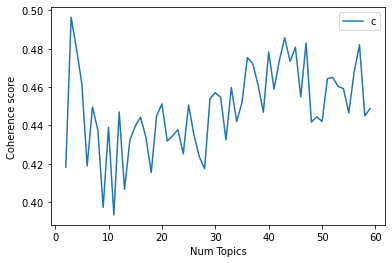

In [48]:
# Show graph
limit=60; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values_lda)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()